In [61]:
# %pip install -r requirements.txt
# %/Applications/Python\ 3.11/Install\ Certificates.command
# %pip install git+https://github.com/tensorflow/examples.git
# !python3 -m pip install --upgrade pip

In [62]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


In [63]:
batch_size = 8
learning_rate = 0.001
buffer_size = 3000
image_size = (96, 96)
output_channels = 2
seed = 420
epochs = 64
model_version = 'v0_1'

- v0_1: initial training, verify the model


In [64]:
# Normalize the images to [0, 1]
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32)
  input_mask = tf.where(input_mask >= 1, 1, 0)
  return input_image, input_mask

def parse_image_and_label(image_path, label_path):
    # Read the image and label files
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_jpeg(label, channels=1) # Labels are grayscale

    # Preprocess the images and labels
    image = tf.image.resize(image, image_size)
    label = tf.image.resize(label, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image, label = normalize(image, label)

    return image, label

def create_dataset(data_dir):
    image_dir = os.path.join(data_dir, 'image')
    label_dir = os.path.join(data_dir, 'seg')
    
    # Assuming file names are the same for images and labels
    image_file_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    label_file_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(parse_image_and_label)
    
    return dataset

# Create the datasets
train_images = create_dataset('data/train')
test_images = create_dataset('data/val')


In [65]:
train_length = len(train_images)
validation_length = len(test_images)
print(f'train_length: {train_length}')
steps_per_epoch = train_length // batch_size


train_length: 19535


In [66]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size, seed=seed)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)


In [67]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


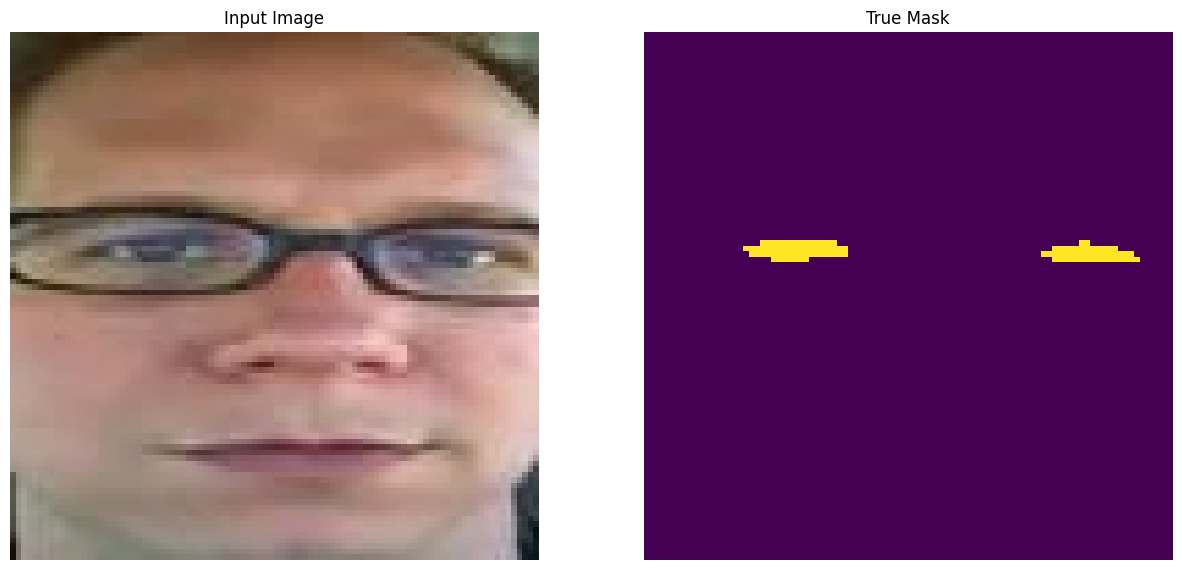

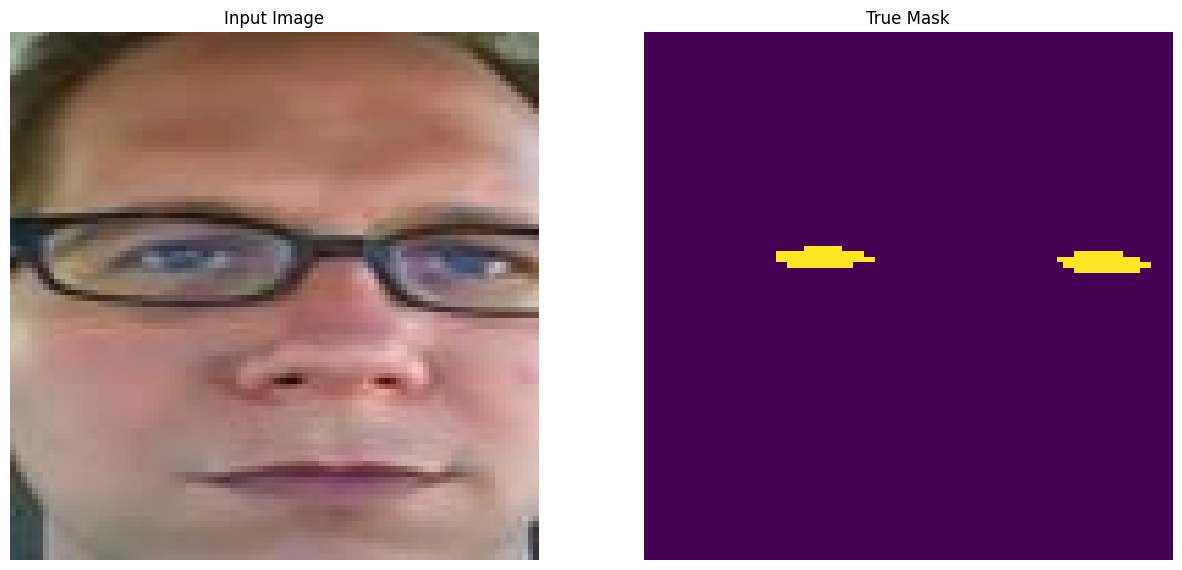

In [68]:
for image, mask in train_images.take(2):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [69]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[image_size[0], image_size[1], 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # Higher resolution features
    'block_3_expand_relu',   # ↓
    'block_6_expand_relu',   # ↓
    'block_13_expand_relu',  # Medium resolution features
    'block_16_project',      # Lower resolution, deeper features
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [70]:
up_stack = [
    pix2pix.upsample(96, 3),
    pix2pix.upsample(48, 3),
    pix2pix.upsample(24, 3),
    pix2pix.upsample(12, 3),
]


In [71]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[image_size[0], image_size[1], 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    # print(x.shape, skip.shape)
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same') 

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [72]:
model = unet_model(output_channels=output_channels)

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 6, 6, 96), (None, 12, 12, 192)]

In [29]:
# tf.keras.utils.plot_model(model)


In [30]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [31]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 1s 800ms/step


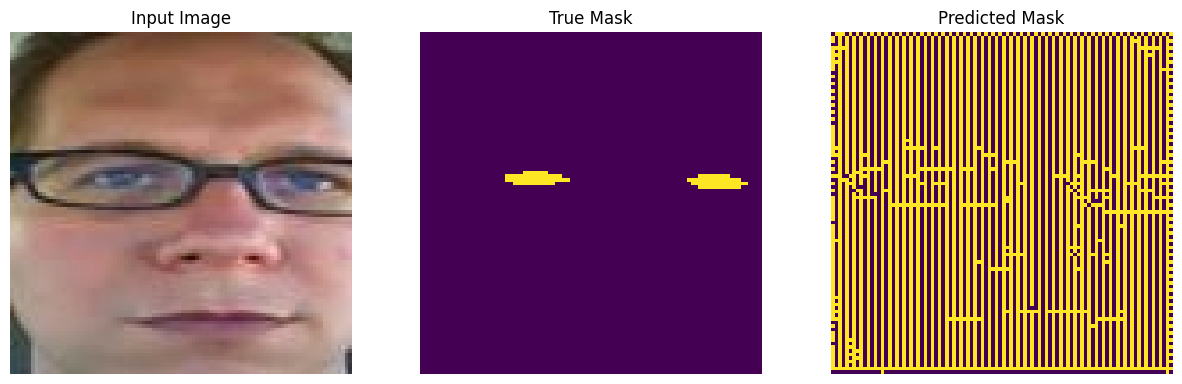

In [32]:
show_predictions()


In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [34]:
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5 
    return lr

1/1 [==============================] - 0s 35ms/step


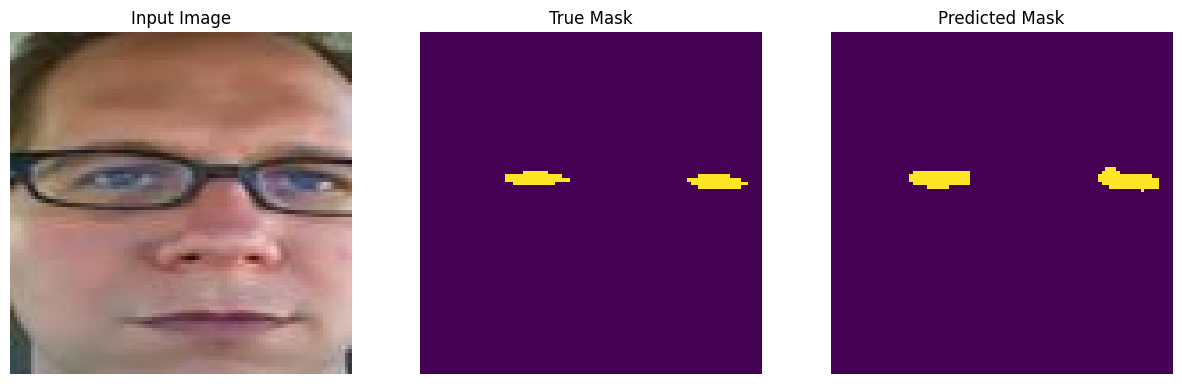


Sample Prediction after epoch 10

2441/2441 [==============================] - 181s 74ms/step - loss: 0.0075 - accuracy: 0.9969 - val_loss: 0.0141 - val_accuracy: 0.9953 - lr: 0.0010


In [35]:
validation_subsplits = 3
validation_steps = validation_length//batch_size//validation_subsplits

lr_scheduler = LearningRateScheduler(lr_schedule)

checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_history = model.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), lr_scheduler, checkpoint, early_stopping])


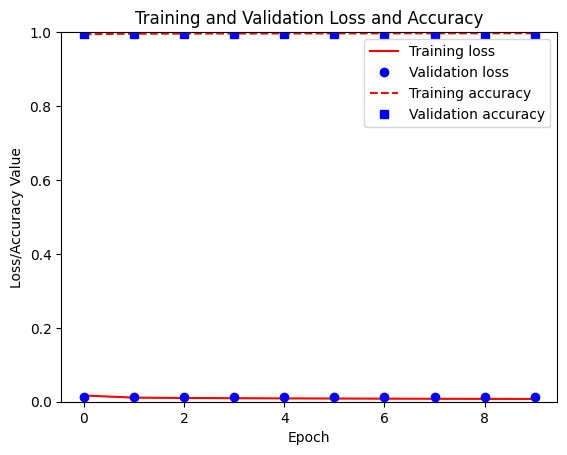

In [36]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

if len(val_loss) < len(loss):
    val_loss += [val_loss[-1]] * (len(loss) - len(val_loss))
if len(val_accuracy) < len(accuracy):
    val_accuracy += [val_accuracy[-1]] * (len(accuracy) - len(val_accuracy))

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.plot(model_history.epoch, accuracy, 'r--', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bs', label='Validation accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


1/1 [==============================] - 0s 63ms/step


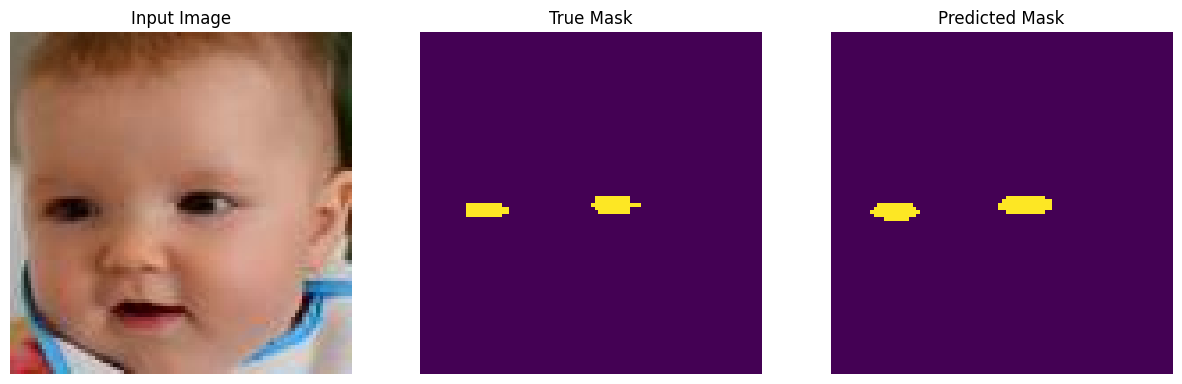

1/1 [==============================] - 0s 34ms/step


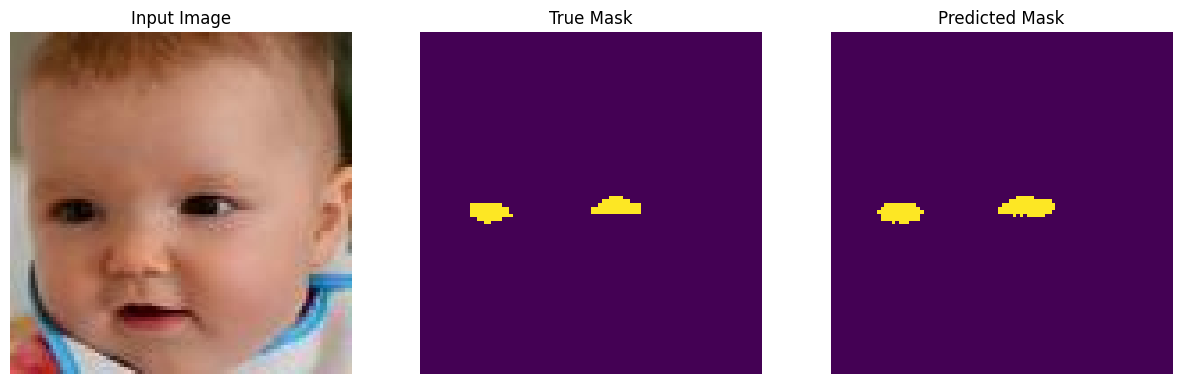

1/1 [==============================] - 0s 43ms/step


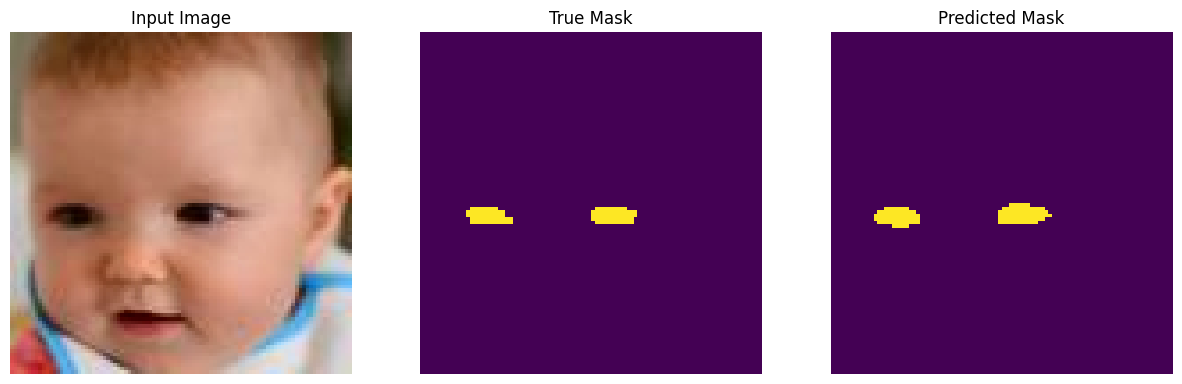

1/1 [==============================] - 0s 34ms/step


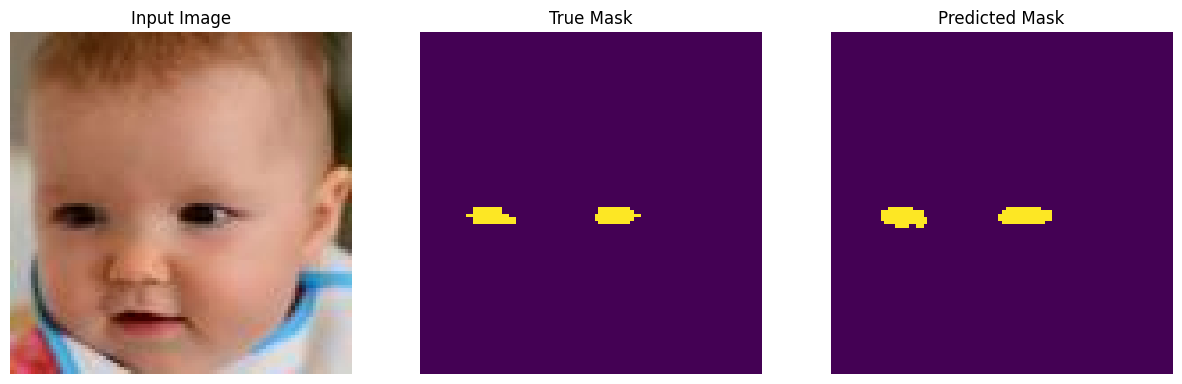

1/1 [==============================] - 0s 34ms/step


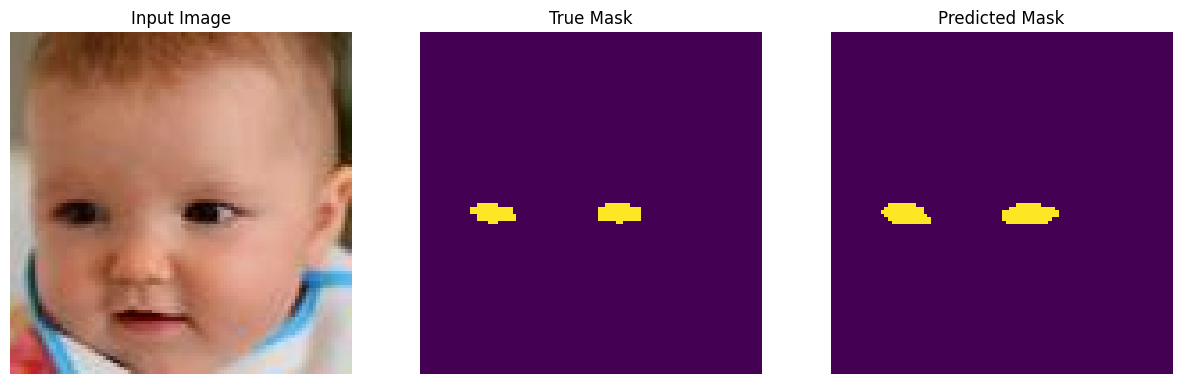

In [38]:
for image, mask in test_images.take(5):
  sample_image, sample_mask = image, mask
  show_predictions()

In [39]:
model.save(f'models/{model_version}.keras')


/usr/local/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(f'models/{model_version}.tflite', 'wb') as f:
  f.write(tflite_model)

2024-11-01 20:23:12.957263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp8fvms1a0/assets


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp8fvms1a0/assets
2024-11-01 20:23:33.741466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-01 20:23:33.741484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-01 20:23:33.743260: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp8fvms1a0
2024-11-01 20:23:33.776497: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-01 20:23:33.776514: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmp8fvms1a0
2024-11-01 20:23:33.838860: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-01 20:23:33.870237: I tensorflow/cc/saved_model/load